In [18]:
!pip install pandas numpy gensim scikit-learn matplotlib seaborn streamlit


In [20]:
import pandas as pd
import numpy as np
import re
import csv
import pickle

from gensim.models import Word2Vec

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


Loading Dataset

In [21]:
import pandas as pd
import csv

df = pd.read_csv(
    "/content/IMDB Dataset.csv",
    sep=",",
    encoding="utf-8",
    quoting=csv.QUOTE_ALL,
    engine="python",
    on_bad_lines="skip"
)

print(df.shape)

(50000, 2)


<Axes: xlabel='sentiment'>

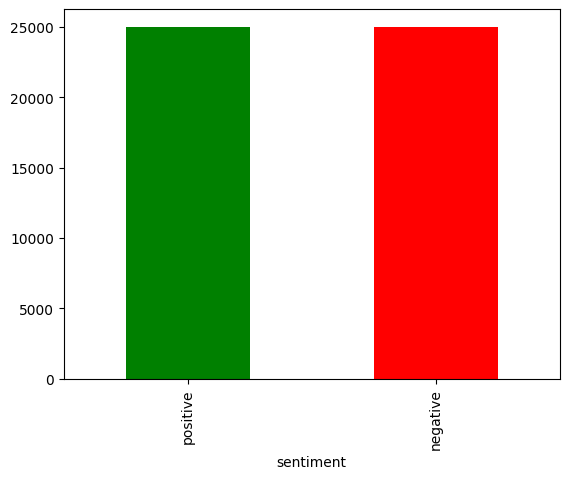

In [22]:
df['sentiment'].value_counts().plot(kind='bar', color=['green','red'])


Text preprocessing

In [23]:
def preprocess_text(review):
    review = re.sub(r'<.*?>', '', review) # remove HTML tags
    review = review.lower() # lowercase
    review = re.sub(r'[^a-z\s]', '', review) # remove punctuation & numbers
    review = re.sub(r'\s+', ' ', review).strip() # remove extra spaces
    return review

df['clean_text'] = df['review'].apply(preprocess_text)

Manual Negation Handling

In [24]:
def mark_negation(review):
    words = review.split()
    negation_words = ["not", "no", "never", "none", "n't"]
    negated = False
    new_words = []
    for word in words:
        if word in negation_words:
            negated = True
            new_words.append(word)
        elif re.match(r'[.!?]', word):
            negated = False
            new_words.append(word)
        elif negated:
            new_words.append(word + "_NEG")
        else:
            new_words.append(word)
    return " ".join(new_words)

df['neg_text'] = df['clean_text'].apply(mark_negation)
df.head()


,review,sentiment,clean_text,neg_text
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...


Train Word2vec model

In [25]:
from gensim.models import Word2Vec

# Tokenize sentences
sentences = [s.split() for s in df['neg_text']]

# Train Word2Vec
w2v_model = Word2Vec(sentences,
                     vector_size=100,
                     window=5, min_count=2,
                     workers=4
)


Convert Sentences

In [26]:
def sentence_vector(sentence, model, size=100):
    words = sentence.split()
    vec = np.zeros(size)
    count = 0
    for w in words:
        if w in model.wv:
            vec += model.wv[w]
            count += 1
    if count != 0:
        vec /= count
    return vec

X = np.array([sentence_vector(s, w2v_model) for s in df['neg_text']])


Encoding Labels

In [27]:
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])  # positive=1, negative=0


Train Test Split

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Train Logistic model

In [29]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=500)

Evaluation

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predict
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)  # for confidence scores

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)


Confusion Matrix:
 [[3924 1076]
 [1046 3954]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79      5000
           1       0.79      0.79      0.79      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Test Accuracy: 0.7878


Cross Validation

In [31]:
cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring="accuracy")
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())



Cross-Validation Scores: [0.7946 0.7838 0.7888 0.7861 0.7854]
Mean CV Accuracy: 0.78774


Training Random forest model

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=42
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

Evaluation

In [33]:
# Predict
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)  # for confidence scores

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

Confusion Matrix:
 [[3863 1137]
 [1250 3750]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.76      5000
           1       0.77      0.75      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

Test Accuracy: 0.7613


In [37]:
def preprocess_and_vectorize(text):
    clean = preprocess_text(text)
    neg = mark_negation(clean)
    vec = sentence_vector(neg, w2v_model)
    return vec.reshape(1, -1)

sample_texts = ["I love this movie", "I dont like that food"]

for text in sample_texts:
    vec = preprocess_and_vectorize(text)
    pred = lr_model.predict(vec)[0]
    prob = lr_model.predict_proba(vec)[0]

    print("Text:", text)
    print("Predicted Sentiment:", "positive" if pred == 1 else "negative")
    print("Confidence [Negative, Positive]:", prob)
    print("----")


Text: I love this movie
Predicted Sentiment: positive
Confidence [Negative, Positive]: [7.63722482e-06 9.99992363e-01]
----
Text: I dont like that food
Predicted Sentiment: negative
Confidence [Negative, Positive]: [0.9440946 0.0559054]
----


In [35]:
pickle.dump(lr_model, open("logistic_w2v_model.pkl", "wb"))
w2v_model.save("w2v_model.model")
